In [ ]:
'''
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")
'''

'\nimport torch\nif torch.backends.mps.is_available():\n    mps_device = torch.device("mps")\n    x = torch.ones(1, device=mps_device)\n    print (x)\nelse:\n    print ("MPS device not found.")\n'

In [ ]:
pip install torch tensorboard onnx torchsummaryX datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import os
import requests
import tarfile
from zipfile import ZipFile
from io import BytesIO
from tqdm import tqdm
from PIL import Image, UnidentifiedImageError
import pandas as pd
from datasets import Dataset
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import torch

# Function to download and unzip dataset
def download_and_unzip(url, extract_to="Datasets", chunk_size=1024*1024):
    response = requests.get(url, stream=True)
    data = b""
    iterations = int(response.headers.get('Content-Length', 0)) // chunk_size + 1
    for _ in tqdm(range(iterations), desc="Downloading dataset"):
        data += response.raw.read(chunk_size)
    zipfile = ZipFile(BytesIO(data))
    zipfile.extractall(path=extract_to)

# Download and extract the IAM Words dataset
dataset_path = os.path.join("Datasets", "IAM_Words")
if not os.path.exists(dataset_path):
    download_and_unzip("https://git.io/J0fjL", extract_to="Datasets")
    tar_file = tarfile.open(os.path.join(dataset_path, "words.tgz"))
    tar_file.extractall(os.path.join(dataset_path, "words"))
    tar_file.close()

# Preprocess dataset
dataset, vocab, max_len = [], set(), 0
words_file = os.path.join(dataset_path, "words.txt")

with open(words_file, "r") as f:
    for line in tqdm(f.readlines(), desc="Processing words.txt"):
        if line.startswith("#") or "err" in line:
            continue

        parts = line.split()
        folder1 = parts[0][:3]
        folder2 = "-".join(parts[0].split("-")[:2])
        file_name = parts[0] + ".png"
        label = parts[-1].strip()

        file_path = os.path.join(dataset_path, "words", folder1, folder2, file_name)
        if os.path.exists(file_path):
            dataset.append({"image": file_path, "text": label})
            vocab.update(label)
            max_len = max(max_len, len(label))

# Limit dataset size (use only half or a smaller portion)
dataset = dataset[:len(dataset) // 20]  # You can adjust the size here (e.g., // 4 for 25%)

# Convert to Hugging Face Dataset
hf_dataset = Dataset.from_list(dataset)

# Load TrOCR processor and model
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

# Preprocess data function with error handling for images
def preprocess_data(examples):
    images = []
    valid_texts = []

    for img_path, text in zip(examples["image"], examples["text"]):
        try:
            img = Image.open(img_path).convert("RGB")
            images.append(img)
            valid_texts.append(text)
        except UnidentifiedImageError:
            print(f"Skipping invalid image: {img_path}")

    if images:
        pixel_values = processor(images=images, return_tensors="pt").pixel_values
        labels = processor.tokenizer(valid_texts, padding="max_length", max_length=max_len, return_tensors="pt").input_ids
        return {"pixel_values": pixel_values, "labels": labels}
    else:
        return {"pixel_values": torch.tensor([]), "labels": torch.tensor([])}

# Convert the dataset into a pandas DataFrame
df = pd.DataFrame(dataset)

# Rename columns
df.rename(columns={"image": "file_name", "text": "text"}, inplace=True)

# Some file names end with jp instead of jpg, let's fix this
df['file_name'] = df['file_name'].apply(lambda x: x + 'g' if x.endswith('jp') else x)

# Display the first few rows
df.head()


Processing words.txt: 100%|██████████| 115338/115338 [00:01<00:00, 87673.69it/s]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.2"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

,file_name,text
0,Datasets/IAM_Words/words/a01/a01-000u/a01-000u...,A
1,Datasets/IAM_Words/words/a01/a01-000u/a01-000u...,MOVE
2,Datasets/IAM_Words/words/a01/a01-000u/a01-000u...,to
3,Datasets/IAM_Words/words/a01/a01-000u/a01-000u...,stop
4,Datasets/IAM_Words/words/a01/a01-000u/a01-000u...,Mr.


In [ ]:

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Display the first few rows of the training and testing data
print("Training DataFrame:")
print(train_df.head())

print("\nTesting DataFrame:")
print(test_df.head())

Training DataFrame:
                                              file_name     text
220   Datasets/IAM_Words/words/a01/a01-003u/a01-003u...      any
1361  Datasets/IAM_Words/words/a01/a01-030u/a01-030u...      the
1010  Datasets/IAM_Words/words/a01/a01-020x/a01-020x...  African
4059  Datasets/IAM_Words/words/a01/a01-132u/a01-132u...       an
2135  Datasets/IAM_Words/words/a01/a01-058/a01-058-0...       He

Testing DataFrame:
                                              file_name  text
4519  Datasets/IAM_Words/words/a02/a02-020/a02-020-0...     ,
1221  Datasets/IAM_Words/words/a01/a01-026x/a01-026x...     ,
2083  Datasets/IAM_Words/words/a01/a01-053x/a01-053x...   had
1044  Datasets/IAM_Words/words/a01/a01-026/a01-026-0...  last
2567  Datasets/IAM_Words/words/a01/a01-072u/a01-072u...   the


In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
print("Training DataFrame:")
print(train_df.head())

print("\nTesting DataFrame:")
print(test_df.head())

Training DataFrame:
                                           file_name        text
0  Datasets/IAM_Words/words/a01/a01-087/a01-087-0...  passionate
1  Datasets/IAM_Words/words/a01/a01-082u/a01-082u...           a
2  Datasets/IAM_Words/words/a01/a01-058x/a01-058x...         get
3  Datasets/IAM_Words/words/a02/a02-024/a02-024-0...           ,
4  Datasets/IAM_Words/words/a02/a02-017/a02-017-0...          he

Testing DataFrame:
                                           file_name     text
0  Datasets/IAM_Words/words/a01/a01-058/a01-058-0...      did
1  Datasets/IAM_Words/words/a01/a01-113u/a01-113u...    first
2  Datasets/IAM_Words/words/a01/a01-087/a01-087-0...   health
3  Datasets/IAM_Words/words/a01/a01-132u/a01-132u...  limited
4  Datasets/IAM_Words/words/a02/a02-032/a02-032-0...      law


In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image, UnidentifiedImageError

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length
        self.valid_data = self.filter_invalid_data()  # Preprocess and filter invalid data

    def __len__(self):
        return len(self.valid_data)

    def filter_invalid_data(self):
        # Filter the dataframe to skip rows with invalid images
        valid_data = []
        for idx, row in self.df.iterrows():
            file_name = row['file_name']
            try:
                # Try to open the image
                Image.open(self.root_dir + file_name).convert("RGB")
                valid_data.append(row)
            except UnidentifiedImageError:
                # Handle invalid images
                print(f"Warning: Skipping invalid image: {file_name}")
        return valid_data

    def __getitem__(self, idx):
        # Get the file name and text for valid data
        row = self.valid_data[idx]
        file_name = row['file_name']
        text = row['text']

        # Open image and process it
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values

        # Tokenize the text and get labels
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # Important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding


In [ ]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = IAMDataset(root_dir='',
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='',
                           df=test_df,
                           processor=processor)

In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 3854
Number of validation examples: 964


In [ ]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


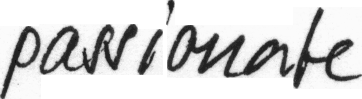

In [ ]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image


In [ ]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

passionate


In [ ]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")
##

In [ ]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [ ]:
import os
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

# Set report_to="none" to disable W&B and other integrations
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True,
    output_dir="./",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
    report_to="none",  # Disable W&B
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
pip install evaluate jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 51.0 MB/s eta 0:00:00


In [ ]:
import evaluate

cer_metric = evaluate.load("cer")

In [ ]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
from transformers import default_data_collator
# Instantiate and train the trainer as usual
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.tokenizer,  # Assuming you use the tokenizer from the processor
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)

trainer.train()

<ipython-input-20-038d0a67d5d1>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss,Validation Loss,Cer
200,0.630900,0.568761,0.213607
400,0.582600,0.510521,0.159267
600,0.199300,0.552562,0.223106
800,0.029700,0.309079,0.092335
1000,0.071600,0.245185,0.072012
1200,0.015400,0.223296,0.061851
1400,0.000200,0.188567,0.051027


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1493: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tra

TrainOutput(global_step=1446, training_loss=0.3617504184466664, metrics={'train_runtime': 1713.9966, 'train_samples_per_second': 6.746, 'train_steps_per_second': 0.844, 'total_flos': 8.651673378295382e+18, 'train_loss': 0.3617504184466664, 'epoch': 3.0})

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!cp -r /content/checkpoint-1446_AOTL /content/drive/MyDrive/
